# Как прикрутить Azure ML к своему ноутбуку

1. Скачиваете **config.json** из VM https://40.68.202.72:8000/ и кладете его в корень рядом с ноутбком, который планируете запускать (если что у каждого свой config файл)

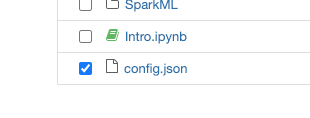

2. Устанавливаете **Azureml SDK**

    `pip install --upgrade azureml-sdk`


3. Подтягиваете конфиг c помощью кода

    - У меня открылось дополнительная вкладка логина в microsoft 😱

   `from azureml.core import Workspace
    ws = Workspace.from_config()`
   

### Успех выглядит так:

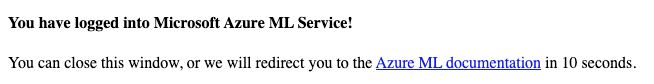

In [2]:
import sys
sys.executable

'/Users/macdrive/GoogleDrive/Проекты/Uplift/sklift-env/bin/python'

In [ ]:
!/Users/macdrive/GoogleDrive/Проекты/Uplift/sklift-env/bin/pip install --upgrade azureml-sdk

In [1]:
from azureml.core import Workspace
ws = Workspace.from_config()

Теперь код из `Intro.ipynb` работает у вас локально

In [4]:
from azureml.core import Dataset

# get the dataset from Azure ML Workspace
aml_dataset = Dataset.get_by_name(ws, 'train_ds', version='latest')
pdf = aml_dataset.take(100).to_pandas_dataframe()

In [16]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
import category_encoders as ce

from sklift.models import TwoModels, SoloModel
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_by_percentile

# Data

In [28]:
data = pd.read_csv('data_sample.csv')    

data.head()

,Unnamed: 0,_c0,cardholder,age,cheque_count_12m_g20,cheque_count_12m_g21,cheque_count_12m_g25,cheque_count_12m_g32,cheque_count_12m_g33,cheque_count_12m_g38,...,sale_sum_6m_g24,sale_sum_6m_g25,sale_sum_6m_g26,sale_sum_6m_g32,sale_sum_6m_g33,sale_sum_6m_g44,sale_sum_6m_g54,stdev_days_between_visits_15d,stdev_discount_depth_15d,stdev_discount_depth_1m
0,52121,52121,16105597,24.0,0.0,1.0,1.0,0.0,2.0,1.0,...,254.41,90.45,0.00,0.0,503.51,347.52,192.96,0.0000,0.2268,0.2268
1,419274,419274,16632516,56.0,0.0,2.0,0.0,0.0,0.0,0.0,...,23.05,0.00,0.00,0.0,0.00,15.12,12.26,0.0000,0.0000,0.0000
2,87178,87178,16604173,53.0,1.0,1.0,4.0,0.0,4.0,2.0,...,744.88,583.29,740.38,0.0,1990.94,573.91,563.70,0.0000,NaN,NaN
3,141909,141909,15950518,33.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.0,0.00,0.00,0.00,2.0817,0.3537,0.3537
4,5874,5874,16284740,50.0,0.0,5.0,3.0,2.0,15.0,16.0,...,903.29,116.87,341.85,497.2,3251.84,1910.61,1736.45,0.0000,0.0000,NaN


In [29]:
target_col = 'response_att'
treatment_col = 'group'

to_delete = ['Unnamed: 0', '_c0', 'cardholder']

data = data.drop(to_delete, axis=1)

In [67]:
X_train, X_val = train_test_split(data,
                                  stratify=data[[target_col, treatment_col]],
                                  test_size=0.3,
                                  random_state=42)

y_train = X_train[target_col]
treat_train = X_train[treatment_col].map({'test': 1, 'control': 0})

y_val = X_val[target_col]
treat_val = X_val[treatment_col].map({'test': 1, 'control': 0})

X_train = X_train.drop([treatment_col, target_col], axis=1)
X_val = X_val.drop([treatment_col, target_col], axis=1)

X_train.shape

(7000, 193)

In [70]:
encoder = ce.TargetEncoder(cols=['gender'])
X_train = encoder.fit_transform(X_train, y_train)
X_val = encoder.transform(X_val)
print(X_train.shape)
X_train['gender'].head()

(7000, 193)


6222    0.100831
3644    0.100831
815     0.100831
22      0.119885
8065    0.119885
Name: gender, dtype: float64

In [72]:
treat_train.value_counts()

1    5248
0    1752
Name: group, dtype: int64

In [73]:
y_train.dtype, treat_train.dtype

(dtype('int64'), dtype('int64'))

# Model logging

In [74]:
import azureml.core
from azureml.core.authentication import InteractiveLoginAuthentication
from azureml.core import Experiment, Workspace

In [82]:
# Get an experiment object from Azure Machine Learning
experiment = Experiment(workspace=ws, name="uplift")

# Create a run object in the experiment
run =  experiment.start_logging()

run.log('model', 'twomodel')
run.log('method', 'ddr_control')

twomodel = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=100, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=100, thread_count=2, random_state=42, silent=True), 
    method='ddr_control')

twomodel.fit(X_train, y_train, treat_train)

uplift_twomodel = twomodel.predict(X_val)

run.log(
    'uplift@k', 
    uplift_at_k(y_val, uplift_twomodel, treat_val, strategy='overall', k=0.25)
)

# Complete the run
run.complete()

In [76]:
run

Experiment,Id,Type,Status,Details Page,Docs Page
uplift,9d44aa76-ff3f-4644-b525-b1367dfd03c4,,Running,Link to Azure Machine Learning studio,Link to Documentation


In [77]:
experiment

Name,Workspace,Report Page,Docs Page
uplift,team09,Link to Azure Machine Learning studio,Link to Documentation
